# YelpClassifier: Sentiment prediction using PyTorch

This year, I started exploring NLP (natural language processing) given its huge potential for building intelligent systems capable of understanding and generating text in human languages. In this exploration, I have developed an understanding of how nlp applications works. I am now engaging myself with building real-life applications.  

This post reflects upon my understanding of NLP and pitch to build a sentiment classifier with the help of an example. The example is taken from the book that I am reading to gain a deeper understanding of nlp from the practical side [**Natural Language Processing with PyTorch: Build Intelligent Language Applications Using Deep Learning**](https://www.oreilly.com/library/view/natural-language-processing/9781491978221/).


I hope this post will be helpful for others who are starting to learn more about NLP.

## Yelp Dataset
In this post, I have used a smaller version of [Yelp dataset](https://github.com/pankajchejara23/nlp_projects/blob/main/yelp_classifier/yelp/reviews_with_splits_lite.csv) which is a dataset of customer's reviews and ratings. The dataset is a processed version of the original dataset. 

For example, in original dataset the ratings are given from 1 to 5, while in this dataset ratings are divied into two categories, i.e., negative and positive. Addtionally, the dataset is already partitioned into train, val and test sets.

Let's see how the records in the yelp dataset look like


In [19]:
import pandas as pd

# reading yelp dataset file
df = pd.read_csv('./yelp/reviews_with_splits_lite.csv')

print('Size:',df.shape[0])

df.head()

Size: 56000


,rating,review,split
0,negative,all i can say is that a i had no other option ...,train
1,negative,i went here once when my long time stylist mov...,train
2,negative,i don t know why i stopped here for lunch this...,train
3,negative,did i order the wrong thing ? or maybe it was ...,train
4,negative,i went here for restaurant week . the restaura...,train


In the dataset, we have three columns: rating, review and split. The first column is the rating assigned by the customers. The second column is the text review and the final column contains labels to decide whether the record belongs to a train, val or test set.

We want to **build a classifier** that can predict the rating given the review. So the text review will be input to the classifier and the rating will be predicted.

The challenge we have here is that the input and output data both are in text format while machine learning works only with numbers. To address this challenge, we need to find a way to transform our text review data into numbers which is also known as vectorization in nlp. 

Let's understand the basic of vectorization. The below image offers an pictorial presentation of vectorization process.


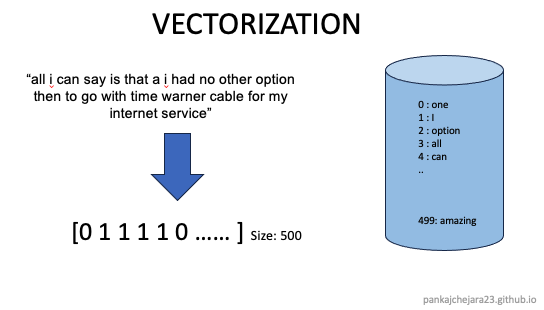

We have a text review that we like to vectorize or convert into a sequence of numbers. There are multiple ways to do that, and we will use the most basic technique for understanding purpose, i.e., using a vocabulary. Vocabulary is a storage that stores words as represented in the above figure. 
In other terms, vocabulary offers a mapping service between words and their stored location (or index). For example, the one shown in the above figure stores 500 words and each word has an associated index. 


The vectorization process will start with creating a vector of size 500. The process then checks which words of vocabulary are present in the text and sets their corresponding values in the vector as 1. 

For example, the first word of the vocabulary (i.e., one) is not present in the review text, therefore, there is 0 in the vector at the start position. Then the next word in the vocabulary is checked (i.e., i). Now this time 'i' is present in the review text, therefore, 1 is stored next in the vector, and so on. This process is repeated for every word stored in the vocabulary.

## Building a machine model to predict rating based on review text
As we have seen in the example above we need to vectorize the review text, and for that we need a vocabulary and a vectorizer.

We will start by creating a vocabulary and vectorizer class.

### Building vocabulary for the review text
The core process of building a vocabulary includes scanning all the text, breaking it into words, and storing unique words. In addition to storing, vocabulary also provides the functionality of mapping between words (or tokens) and their respective indices (i.e., where those words are stored).

The following class offers those functionalities. There is a possibility that during the vectorization process, we are likely to have words that are not available in the vocabulary. To handle those cases, we can store some special words representing all unavailable words, e.g., '\<UNK\>'.

In [20]:
class Vocabulary(object):
    def __init__(self, token_to_idx = None, add_unk=True, unk_token='<UNK>'):
        """
        params:
            token_to_idx (dict): mapping from token to index
            add_unk (bool): flag to add a special token to the vocabulary for unknowns tokens
            unk_token (str): Token used as special token
        
        """
        if token_to_idx is None:
            token_to_idx ={}
        
        self._token_to_idx = token_to_idx
        self._idx_to_token = {idx:token for token,idx in token_to_idx}
        
        self._add_unk = add_unk
        self._unk_token = unk_token
        
        self.unk_index = -1
        if add_unk:
            self.unk_index = self.add_token(unk_token)
            
    def to_serialize(self):
        """ function to serialize the content of vocabulary
        """
        return {'idx_to_token':self._idx_to_token,
               'add_unk':self._add_unk,
               'unk_token':self._unk_token}
    
    @classmethod
    def from_serializable(cls,contents):
        """
        class function to create a vocabulary from serialized content
        """
        return cls(**contents)
    
    def add_token(self,token):
        """
        Add token to the vocabulary
        
        params:
            token (str): token to add to the vocabulary
            
        returns:
            idx (int): index of token
        
        """
        if token in self._token_to_idx:
            return self._token_to_idx[token]
        else:
            idx = len(self)
            self._token_to_idx[token] = idx
            self._idx_to_token[idx] = token
        return idx
    
    
    def lookup_idx(self,idx):
        """
        Lookup vocabulary to fetch  token at idx
        
        params:
            idx(int) : index of token to be fetched
            
        returns:
            token (str): token stored at idx
        """
        if idx not in self._idx_to_token:
            raise KeyError("Vocabulary does not have token with specified index:"%idx)
        return self._idx_to_token[idx]
    

    def lookup_token(self,token):
        """
        Lookup vocabulary to fetch index of a token
        
        params:
            token(str): token to lookup
            
        returns:
            idx (int): index of token
        """
        
        if token not in self._token_to_idx:
            return self.unk_index
        else:
            return self._token_to_idx[token]
    
    def __len__(self):
        return len(self._idx_to_token)
    
    
    def __str__(self):
        return "Vocabulary (size = %d)" % len(self)
    
    

#### Examples of Vocabulary class

Let's see one example of using Vocabulary class for the following text. 

```
text = """This is a good example of illustrating the use of pytorch for natural language processing. The example shows how to build a vocabulary which is a collection of words and their mapping to their corresponding indices. """
```

In [21]:
# raw text
text = """This is a good example of illustrating the use of pytorch for natural language processing. The example shows how to build a vocabulary which is a collection of words and their mapping to their corresponding indices. """

#preparing a vocabulary object
voc = Vocabulary(add_unk=True)

#adding token to the vocabulary
for word in text.strip().split(' '):
    voc.add_token(word)

#printing vocabulary mapping
print(voc._token_to_idx)


{'<UNK>': 0, 'This': 1, 'is': 2, 'a': 3, 'good': 4, 'example': 5, 'of': 6, 'illustrating': 7, 'the': 8, 'use': 9, 'pytorch': 10, 'for': 11, 'natural': 12, 'language': 13, 'processing.': 14, 'The': 15, 'shows': 16, 'how': 17, 'to': 18, 'build': 19, 'vocabulary': 20, 'which': 21, 'collection': 22, 'words': 23, 'and': 24, 'their': 25, 'mapping': 26, 'corresponding': 27, 'indices.': 28}


As we can see that each word mapped to an index. We also have one special token '\<UNK\>'. To see its usage, we will perform a lookup for a word which is not in the vocabulary.

In [11]:
# lookup for the word 'estonia'
print(voc.lookup_token('estonia'))

0


The vocabulary simply returned the index of '\<UNK\>'. 

## Vectorizer
Now, let's move to the vectorization process. This is the process where we will transform review text into vectors. These vectors will contain indices of each word in the review text.

For example, let's say we have a text "how to build" which we want to vectorize. For that, we need a mapping (token to index) or vocabulary where we have information about indices of tokens.

If we use our demo vocabulary from the above example then "how to build" will be transformed into a vector.

In [22]:
# creating a list of vocabulary size
vector = [0]* len(voc)

# lookup for each token in the sentence
for token in "how to build".split(' '):
    
    # fetch index of the current token
    index = voc.lookup_token(token)
    
    # set the value at index as 1
    vector[index] = 1
print('Vectorized version:',vector)

Vectorized version: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Now, that we have an idea of what vectorizer does, we will move to create a vectorizer class offering text-to vector transformation functionality.

In [23]:
class ReviewVectorizer(object):
    """
    Vectorizer class to transform review text into vectors
    """
    def __init__(self,review_vocab, rating_vocab):
        """
        params:
            review_vocab (Vocabulary): vocabulary object for review text
            rating_vocab (Vocabulary): vocabulary obejct for rating 
        """
        self.review_vocab = review_vocab
        self.rating_vocab = rating_vocab 
        
    def vectorize(self,text):
        """
        perform vectorization of given text
        
        params:
            text (str): review text to transform into vector
            
        returns:
            one_hot (array): returns one-hot encoding of text
        """
        one_hot = np.zeros(len(self.review_vocab),dtype=np.float32)
        
        # iterate over each word in the  text
        for word in text.strip().split():
            # avoid if the word is a punctuation
            if word not in string.punctuation:
                # fetching index of the word 
                idx = self.review_vocab.lookup_token(word)
                
                # setting 1 at idx index
                one_hot[idx] = 1
                
        return one_hot
        
    @classmethod
    def from_dataframe(cls,review_df,cutoff=25):
        """
        This function builds vocabulary for review text and rating.
        
        params:
            review_df (pandas.DataFrame): dataframe containing yelp dataset
            cutoff (int): a threshold to store words into vocabulary
            
        returns:
            ReviewVectorizer object
        """
        review_vocab = Vocabulary(add_unk=True)
        rating_vocab = Vocabulary(add_unk=False)
        
        # adding all unique rating to the rating_vocubulary
        for rating in review_df['rating'].unique():
            rating_vocab.add_token(rating)
            
        word_count = {}
        
        # counting frequency of each word which appeared in the review text
        for review in review_df.review:
            for word in review.strip().split(' '):
                if word not in string.punctuation:
                    if word in word_count.keys():
                        word_count[word] += 1
                    else:
                        word_count[word] = 1
        
        # adding tokens from review text to the review vocabulary
        for word,count in word_count.items():
            if count > cutoff:
                review_vocab.add_token(word)
        
        return cls(review_vocab,rating_vocab)
    
    @classmethod
    def from_serializable(cls, contents):
        """
        class function to create ReviewVectorizer from serialzed contents
        
        params:
            contents(dict): a dictionary containing contents for review and rating vacabulary
        
        returns:
            ReviewVectorizer object
        """
        
        return cls(review_vocab = Vocabulary.from_serialiazable(contents['reivew_vocab']),
                  rating_voca = Vocabulary.from_serializable(contents['rating_vocab']))
    
    def to_serializable(self):
        """
        To serialize vocabularies 
        
        returns:
            contents (dict): contents of review and rating vocabularies
        
        """
        return {'review_vocab':self.review_vocab.to_serializable(),
               'rating_vocab':self.rating_vocab.to_serializable()}

Now, we have vocabulary and vectorizer classes ready. Next, we need to create a dataset class inherting pytorch's `Dataset` class. This class enables uses of pytorch functionality with out dataset.

### Creating Dataset 
Before training a machine learning model, usually there are some preprocessing tasks, e.g., vectorizing the text, converting images to tensors, etc. These tasks are generally performed separately from the model training. PyTorch offers a systematic way to abstract those tasks. Here, we will see the use of two classes 'Dataset' and 'DataLoader'. 

The first class is related to reading data files, performing some preprocessing tasks, and fetching training instances. While the second class offers a wrapper around the dataset class to fetch data in batches for training.

Let's dive into the code.

In [31]:

class YelpDataset(Dataset):
    """
    Dataset class utilizing pytorch Dataset template
    
    """
    def __init__(self, review_df, vectorizer):
        """
        review_df (pandas.DataFrame): dataframe containing yelp data records
        vectorizer (ReviewVectorizer): ReviewVectorizer object
        """
        self.review_df = review_df
        self._vectorizer =  vectorizer 
        
        self.train_df = self.review_df[self.review_df.split=='train']
        self.train_size = self.train_df.shape[0]
        
        self.val_df = self.review_df[self.review_df.split=='val']
        self.val_size = self.val_df.shape[0]
        
        self.test_df = self.review_df[self.review_df.split=='test']
        self.test_size = self.test_df.shape[0]
        
        self._lookup_dict = {'train':(self.train_df,self.train_size),
                             'val':(self.val_df,self.val_size),
                             'test':(self.test_df,self.test_size)}
        
        self.set_split('train')
        
    def get_vectorizer(self):
        return self._vectorizer
        
    @classmethod
    def load_dataset_and_make_vectorizer(cls,review_csv):
        """class function to load dataset and initialize the vectorizer
        
        params: 
            review_csv (str): file_name
        
        returns:
            ReviewDataset object
        """
        
        review_df = pd.read_csv(review_csv)
        train_review_df = review_df[review_df.split=='train']
        
        return cls(review_df,ReviewVectorizer.from_dataframe(train_review_df))
        
    def set_split(self,split='train'):
        """
        function to set the current active dataset
        
        params:
            split (str): specify part of dataset to be used
        
        """
        self._target_split = split
        self._target_df, self._target_size = self._lookup_dict[split]
        
    def __len__(self):
        return self._target_size
        
    def __getitem__(self,idx):
        """
        function to fetch record at index idx
        
        params:
            idx (int): index of record to be fetched
        """
        row = self._target_df.iloc[idx]
        review_vector = self._vectorizer.vectorize(row.review)
        review_rating = self._vectorizer.rating_vocab.lookup_token(row.rating)
        return {'x_data':review_vector,
               'y_target':review_rating}
    
    def get_num_batches(self,batch_size):
        return self._target_size//batch_size

To create a custom 'Dataset' class, two functions must be defined, i.e., __len__, __getitem__. The first function returns the length of the dataset and the second function fetches the training instance at a given index. 

In our YelpDataset class, we have added some more functions as well to simplify the loading of training, validation, and test sets. 

In [32]:
# checking the dataset
yelpDB = YelpDataset.load_dataset_and_make_vectorizer('./yelp/reviews_with_splits_lite.csv')

In [33]:
for split in ['train','test','val']:
    yelpDB.set_split(split)
    print(f'Split:{split}     Size:{len(yelpDB)}')

Split:train     Size:39200
Split:test     Size:8400
Split:val     Size:8400


We have our dataset ready. We can now make use of DataLoader from Pytorch to get data instanes in batches.

### DataLoader 

The following function creates a dataloader for our Yelp dataset. This dataloader return data in batches.

In [35]:
import string
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import numpy as np

def generate_batches(dataset, batch_size, shuffle=True,drop_last=True):
    """
    function to get data batches
    @ This code is targetted for cpu machines.
    
    params:
        dataset (YelpDataset): YelpDataset object
        batch_size (int): data batch size
        shuffle (bool): Whether to shuffle data
        drop_last (bool): flag to drop the last batch if it is less than the batch size
        
    """
    
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size,
                            shuffle=shuffle, drop_last=drop_last)
    for data_dict in dataloader:
        out_data_dict = {}
        
        for name,tensor in data_dict.items():
            out_data_dict[name] = data_dict[name]
        yield out_data_dict

Let's see now how one batch look like.

In [39]:
batch = next(iter(generate_batches(yelpDB,batch_size=100)))
print('Size:',batch['x_data'].size())
print('Batch example:',batch)

Size: torch.Size([100, 7356])
Batch example: {'x_data': tensor([[1., 1., 1.,  ..., 0., 0., 0.],
        [1., 0., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        ...,
        [1., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.]]), 'y_target': tensor([0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1,
        1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1,
        1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0,
        0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0,
        0, 1, 0, 1])}


### Building the classifier
Now, we will move to build our neural network to classify review text into positive or negative categories of rating.
To build a custom neural network, the 'Module' class needs to be inherited. The following class does that. 

Next, during the initialization (i.e., inside the __init__ function) neural network architecture is specified. In our case, we have having a single Linear layer.

Finally, in the forward function the computation is performed. In the following class, we are simply performing linear computation of the form $W*X$ where $W$ represent weights and $X$ represent input data. On the computed result, the sigmoid function is applied. 

In [46]:
import torch
from torch import nn
from torch.nn import functional as F


class ReviewClassifier(nn.Module):
    """
    ReviewClassifier class
    """
    def __init__(self,input_size):
        """
        Initialize the classifier
        params:
            input_size (int): number of features
        """
        super(ReviewClassifier,self).__init__()
        self.fc1 = nn.Linear(in_features = input_size,
                             out_features = 1)
        
    def forward(self,inputs,apply_sigmoid = False):
        """
        function performing forward pass
        params:
            inputs (tensor): input vectors
            apply_sigmoid (bool): flag whether to apply sigmoid function or not
            
        returns:
            y_out (tensors): shape (batch_size,)
        """
        y_out = self.fc1(inputs).squeeze()
        if apply_sigmoid:
            y_out = F.sigmoid(y_out)
        return y_out

### Training the neural network
We will load our database which will create a vocabulary and vectorizer. We then get the vectorizer and initialize our classifier.

In [47]:
# loading the dataset
yelpDB = YelpDataset.load_dataset_and_make_vectorizer('./yelp/reviews_with_splits_lite.csv')

# getting the vectorizer
vectorizer = yelpDB.get_vectorizer()

# initializing the classifier
classifier = ReviewClassifier(len(vectorizer.review_vocab))

In [48]:
def compute_accuracy(y_pred,y_target):
    """
    function to compute accuracy metrics using logits
    """
    # applying sigmoid function and generating predicted class indices based on .5 threshold
    y_pred_indices = (torch.sigmoid(y_pred) > 0.5).long()

    # counting correctly predicted instances
    n_correct = (y_pred_indices == y_target).sum().item()
    
    return n_correct / len(y_pred_indices) * 100

Now, we will move to the most fun part of building our classifier, i.e., training the neural network with the yelp dataset. During the training, we iterate over several epochs. During each epoch, training occurs on the complete training dataset.

For each epoch, we start by setting the gradients of the optimizer as zero. Then, we perform a forward pass where computation is performed on the input data. The output of the classifier is used to compute the loss which is then used to make a backward pass. Finally, the weight parameters are updated. We have also included code to compute running loss and accuracy for training and validation both.

:::{.important}

    During validation and testing, we only perform the forward pass.
    
:::

In [51]:
from torch import optim

# for reproducibility
np.random.seed(3223)
torch.manual_seed(3223)

# loss function
loss_func = nn.BCEWithLogitsLoss()

# optimizer
optimizer = optim.Adam(classifier.parameters(),lr=.0001)

num_epochs = 20
batch_size = 100

# iterate over number of epochs
for epoch in range(num_epochs):
    
    # set the split to use training data
    yelpDB.set_split('train')
    
    batch_generator = generate_batches(yelpDB,batch_size=batch_size)
    
    train_running_loss = 0.0
    train_running_acc = 0.0
    
    classifier.train()

    for batch_index, batch_dict in enumerate(batch_generator):
        
        # zeros the optimizer gradients
        optimizer.zero_grad()
        
        # forward pass
        y_pred = classifier(batch_dict['x_data'].float())
        
        # computing loss
        loss = loss_func(y_pred,batch_dict['y_target'].float())
        
        loss_t = loss.item()
        
        train_running_loss += (loss_t - train_running_loss)/ (batch_index + 1)
        
        acc_t = compute_accuracy(y_pred,batch_dict['y_target'])
        
        train_running_acc += (acc_t - train_running_acc) / (batch_index + 1)
        
        # backward pass
        loss.backward()
        
        # updating the weight parameters
        optimizer.step()

    # setting the split to use validation set
    yelpDB.set_split('val')
    
    # batch generator
    batch_generator = generate_batches(yelpDB,batch_size=batch_size)
    val_running_loss = 0.0
    val_running_acc = 0.0
    classifier.eval()
    for batch_index, batch_dict in enumerate(batch_generator):
        
        # output of neural network
        y_pred = classifier(batch_dict['x_data'].float())
        
        # coputing loss
        loss = loss_func(y_pred,batch_dict['y_target'].float())
        
        loss_t = loss.item()
        
        val_running_loss += (loss_t - val_running_loss)/ (batch_index + 1)
        
        acc_t = compute_accuracy(y_pred,batch_dict['y_target'])
        val_running_acc += (acc_t - val_running_acc) / (batch_index + 1)
        
    print('\nEpoch :{}'.format(epoch))
    print('  Training   ==> Loss: {:.2f} Accuracy: {:.2f}'.format(train_running_loss,train_running_acc))
    print('  Validation ==> Loss: {:.2f} Accuracy: {:.2f}'.format(val_running_loss,val_running_acc))

    


Epoch :0
  Training   ==> Loss: 0.64 Accuracy: 72.57
  Validation ==> Loss: 0.60 Accuracy: 82.32

Epoch :1
  Training   ==> Loss: 0.57 Accuracy: 83.34
  Validation ==> Loss: 0.54 Accuracy: 84.48

Epoch :2
  Training   ==> Loss: 0.52 Accuracy: 84.79
  Validation ==> Loss: 0.50 Accuracy: 85.15

Epoch :3
  Training   ==> Loss: 0.48 Accuracy: 85.93
  Validation ==> Loss: 0.46 Accuracy: 85.92

Epoch :4
  Training   ==> Loss: 0.45 Accuracy: 86.85
  Validation ==> Loss: 0.44 Accuracy: 86.58

Epoch :5
  Training   ==> Loss: 0.42 Accuracy: 87.57
  Validation ==> Loss: 0.42 Accuracy: 87.19

Epoch :6
  Training   ==> Loss: 0.40 Accuracy: 88.26
  Validation ==> Loss: 0.40 Accuracy: 87.82

Epoch :7
  Training   ==> Loss: 0.38 Accuracy: 88.91
  Validation ==> Loss: 0.38 Accuracy: 88.40

Epoch :8
  Training   ==> Loss: 0.37 Accuracy: 89.40
  Validation ==> Loss: 0.37 Accuracy: 88.93

Epoch :9
  Training   ==> Loss: 0.35 Accuracy: 89.82
  Validation ==> Loss: 0.35 Accuracy: 89.24

Epoch :10
  Trainin

## Evaluation on test data


Now, we will see how well our classfier performs on test set.

In [52]:
yelpDB.set_split('test')
    
batch_generator = generate_batches(yelpDB,batch_size=batch_size)
    
test_running_loss = 0.0
test_running_acc = 0.0
    
classifier.eval()

    
for batch_index, batch_dict in enumerate(batch_generator):
    y_pred = classifier(batch_dict['x_data'].float())
    loss = loss_func(y_pred,batch_dict['y_target'].float())
    loss_t = loss.item()
    test_running_loss += (loss_t - test_running_loss)/ (batch_index + 1)
    acc_t = compute_accuracy(y_pred,batch_dict['y_target'])
    test_running_acc += (acc_t - test_running_acc) / (batch_index + 1)
    

print('  Test   ==> Loss: {:.2f} Accuracy: {:.2f}'.format(test_running_loss,test_running_acc))
   

  Test   ==> Loss: 0.29 Accuracy: 90.33


# References
1. https://github.com/delip/PyTorchNLPBook
2. https://pytorch.org/tutorials/beginner/basics/data_tutorial.html